# Defining and using symmetries

In most FDTD simulations, you can use field symmetries to significantly reduce computation by 1/2, 1/4, or even 1/8, potentially saving significant time. Symmetries are also useful to filter out undesired light polarizations. To correctly set up the symmetries in a simulation, it is necessary to consider the geometry of structures and source planes, as well as the vectorial nature of the fields. This notebook will give a tutorial on setting up symmetries in [Tidy3D](https://www.flexcompute.com/tidy3d/solver/). This [notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/PhotonicCrystalWaveguidePolarizationFilter/) shows a good example on how to set up symmetries to select between different waveguide modes.

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/tidy3d/learning-center/fdtd101/) tutorials. 

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

## How Can I Set Symmetry?
You should set the `symmetry` parameter in your [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html) object using a tuple of integers defining reflection symmetry across a plane bisecting the simulation domain normal to the `x`-, `y`-, and `z`-axis. Each element can be **0** (*no symmetry*), **1** (*even, i.e. ‘PMC’ symmetry*) or **-1** (*odd, i.e. ‘PEC’ symmetry*). Note that the vectorial nature of the fields must be considered to determine the symmetry value correctly. 

The figure below illustrates how the electric and magnetic field components transform under PEC- and PMC-like symmetry planes. You can refer to this figure when considering whether a source field conforms to a PEC- or PMC-like symmetry axis. This would be helpful, especially when dealing with optical waveguide modes.

<img src="img/pec_pmc.png" alt="PEC and PMC Boundary Conditions"  width="400" align="center"/>

We can refer to this figure in the following examples to properly adjust symmetry.

## Symmetry Example 1: Reflectance From a Metasurface
In this first example, we will build a dielectric metasurface and calculate its reflectance. A plane wave source will illuminate the structure at the normal direction.

In [2]:
# Simulation wavelength
wl_min = 0.4
wl_max = 0.8
n_wl = 201
wl_c = (wl_min + wl_max) / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq_c = td.C_0 / wl_c
freq_range = td.C_0 / wl_range
freq_bw = 0.5 * (freq_range[0] - freq_range[-1])
run_time = 1e-12

# Geometry
p = 0.35
t = 0.27
w = 0.255
sub_t = 2
clad_t = 2

# Material
n = 2.00
ns = 1.46
mat_brick = td.Medium(permittivity=n ** 2)
mat_sub = td.Medium(permittivity=ns ** 2)

The metasurface structure is composed of a periodic pattern of dielectric nanoresonators. First, we will use no symmetry.

In [3]:
# Simulation size.
size_z = sub_t + t + clad_t
_inf = 10

# Substrate.
sub_box = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-_inf, -_inf, -_inf), rmax=(_inf, _inf, -size_z / 2 + sub_t)
    ),
    medium=mat_sub,
)

# Nanoresonator.
res_box = td.Structure(
    geometry=td.Box(center=(0, 0, -size_z / 2 + sub_t + t / 2), size=(w, w, t)),
    medium=mat_brick,
)

# Create a plane wave excitation source.
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq_c, fwidth=freq_bw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, size_z / 2 - wl_c / 2),
    direction="-",
    pol_angle=0,
    angle_theta=0,
)

# Create a flux monitor to measure the reflectance.
ref_monitor = td.FluxMonitor(
    center=(0, 0, size_z / 2 - wl_c / 3),
    size=(td.inf, td.inf, 0),
    freqs=freq_range,
    name="R",
)

# Simulation.
sim_met_no_sym = td.Simulation(
    size=(p, p, size_z),
    center=(0, 0, 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=40, wavelength=(wl_min + wl_max) / 2),
    structures=[sub_box, res_box],
    sources=[plane_wave],
    monitors=[ref_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ),
    symmetry=(0, 0, 0),
)

Let's look at the metasurface unit cell before running the simulation to ensure all the components are in their correct places. You can observe that both the structure and source plane have mirror symmetry about the `x`- and `y`-axis.

In [4]:
sim_met_no_sym.plot_3d(width=400, height=400)

We will run the simulation with `verbose=False` to reduce the amount of output information.

In [5]:
job_no_sym = web.Job(
    simulation=sim_met_no_sym, task_name="sim_met_no_symmetry", verbose=False
)
sim_data_no_sym = job_no_sym.run(path="data/simulation_data.hdf5")

We should now consider the source field components concerning the symmetry axis to correctly include symmetry conditions. Both the electric field `Ex` and the magnetic field `Hy` should be continuous at the symmetry plane perpendicular to the `x`-direction, so we will set the symmetry to **-1** (*odd, i.e. ‘PEC’ symmetry*) in the `x`-direction. These field components also should be continuous with respect to the symmetry plane at the `y`-direction, but in this case, the `Ex` field component is parallel, and `Hy` is perpendicular to that symmetry plane. This case conforms to a PMC-like symmetry plane (as one can observe in the schematic "PEC PMC" figure), which we will obtain by adjusting the symmetry to **1** (*even, i.e. ‘PMC’ symmetry*) in the `y`-direction.

We can modify the previous simulation and change the symmetry condition to `(-1, 1, 0)`. After that, we can plot the simulation set up again. If you enable the symmetry visualization, you will see the "PEC" domain highlighted in red and the "PMC" region in blue.

In [6]:
sim_met_sym = sim_met_no_sym.copy(update={"symmetry": (-1, 1, 0)})
sim_met_sym.plot_3d(width=400, height=400)

In [7]:
job_sym = web.Job(
    simulation=sim_met_sym, task_name="sim_met_no_symmetry", verbose=False
)
sim_data_sym = job_sym.run(path="data/simulation_data.hdf5")

Lastly, we should compare the reflectance spectra obtained in both cases. As one can see below, they match exactly, confirming we have correctly set the symmetry in the second simulation.

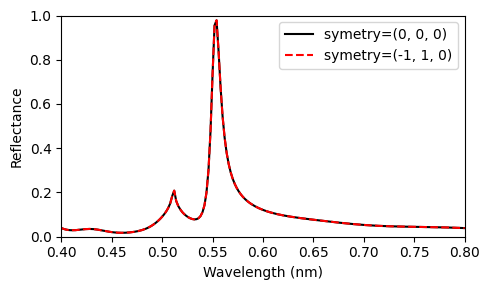

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)

ax.plot(wl_range, sim_data_no_sym["R"].flux, "-k", label="symetry=(0, 0, 0)")
ax.plot(wl_range, sim_data_sym["R"].flux, "--r", label="symetry=(-1, 1, 0)")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance")
ax.set_ylim(0, 1)
ax.set_xlim(wl_range[0], wl_range[-1])
plt.legend()
plt.show()

## Symmetry Example 2: Straight Dielectric Waveguide
Let's look at a simple dielectric waveguide and observe how to use the symmetry parameters to reduce computation and select between the transverse electric (TE) and transverse magnetic (TM) propagating modes with specific symmetries.

In [9]:
# Simulation parameters.
wl = 1  # Wavelength (um).
bw = 0.1  # Simulation bandwidth (um).

# Geometry.
wg_length = 10
wg_height = 0.5
wg_width = 2

# Material.
wg_n = 2

# Simulation size.
size_x = wg_length
size_y = wg_width + 2 * wl
size_z = wg_height + 2 * wl

# Source and Monitor frequencies.
wl_range = np.linspace(wl - bw / 2, wl + bw / 2, 101)
freq = td.C_0 / wl
freq_range = td.C_0 / wl_range
freqw = 0.5 * (freq_range[0] - freq_range[-1])
run_time = 1e-12

We will create the waveguide geometry first.

In [10]:
wg_medium = td.Medium(permittivity=wg_n ** 2)
wg_structure = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(2 * wg_length, wg_width, wg_height)),
    medium=wg_medium,
)

Then, we will create a function that receives a tuple containing the symmetry specification, build and run a [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.mode.ModeSolver.html#tidy3d.plugins.mode.ModeSolver), and return a `ModeData` and the `Simulation` objects. As we are only interested in the mode field distribution, we will run the `ModeSolve` locally. However, when you need more accurate results, you can run it on the server side to take advantage of `subpixel averaging`.

In [11]:
def build_simulation(symm=(0, 0, 0), n_modes=4):
    # Simulation object.
    sim = td.Simulation(
        size=(size_x, size_y, size_z),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wl),
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        run_time=run_time,
        structures=[wg_structure],
        symmetry=symm,
    )

    # Mode Solver object.
    plane = td.Box(center=(-size_x / 2 + 0.5 * wl, 0, 0), size=(0, size_y, size_z))

    mode_spec = td.ModeSpec(
        num_modes=n_modes,
        target_neff=wg_n,
    )

    mode_solver = ModeSolver(
        simulation=sim,
        plane=plane,
        mode_spec=mode_spec,
        freqs=[freq],
    )

    mode_data = mode_solver.solve()

    # Include a mode source in the simulation.
    source_time = td.GaussianPulse(freq0=freq, fwidth=freqw)
    mode_src = mode_solver.to_source(
        mode_index=0, source_time=source_time, direction="+"
    )
    sim = sim.copy(update={"sources": [mode_src]})

    return mode_data, sim

In addition, we will define a function to plot the mode field distribution and draw the symmetry axis in the y- and z-directions. Red refers to **-1** (*odd, i.e. ‘PEC’ symmetry*) and blue to **1** (*even, i.e. ‘PMC’ symmetry*).

In [12]:
def plot_modes(mode_data, mode_index=0, label="TE", axis_y="red", axis_z="blue"):
    fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(12, 5))
    sx = np.asarray(
        mode_data.Ey.isel(mode_index=mode_index, f=0, drop=True).squeeze().real.T.y
    ).size
    sy = np.asarray(
        mode_data.Ey.isel(mode_index=mode_index, f=0, drop=True).squeeze().real.T.z
    ).size

    ax[0].imshow(
        mode_data.Ey.isel(mode_index=mode_index, f=0, drop=True).squeeze().real.T,
        cmap="RdBu",
    )
    ax[0].axvline(x=sx / 2, color=axis_y)
    ax[0].set_title(label + ": Ey")
    ax[0].axis("off")
    ax[1].imshow(
        mode_data.Ez.isel(mode_index=mode_index, f=0, drop=True).squeeze().real.T,
        cmap="RdBu",
    )
    ax[1].axvline(x=sx / 2, color=axis_y)
    ax[1].set_title(label + ": Ez")
    ax[1].axis("off")
    ax[2].imshow(
        mode_data.Hy.isel(mode_index=mode_index, f=0, drop=True).squeeze().real.T,
        cmap="RdBu",
    )
    ax[2].axhline(y=sy / 2, color=axis_z)
    ax[2].set_title(label + ": Hy")
    ax[2].axis("off")
    ax[3].imshow(
        mode_data.Hz.isel(mode_index=mode_index, f=0, drop=True).squeeze().real.T,
        cmap="RdBu",
    )
    ax[3].axhline(y=sy / 2, color=axis_z)
    ax[3].set_title(label + ": Hz")
    ax[3].axis("off")
    plt.show()

### Symmetry (0, 0, 0)
We will create a simulation using no symmetries and take a look at the generated 3D model. We can observe that the structure itself has mirror symmetries about the `x`-, `y`-, and `z`-axis. However, the source plane position breaks the symmetry about the `x`-axis, and the simulation ends up with symmetries only about `y` and `z`.It is worth mentioning that if the waveguide sidewall angle is other than zero, or the top cladding and the substrate are not the same material, we would have symmetry about the `y`-axis only.

In [13]:
mode_data, sim = build_simulation(symm=(0, 0, 0), n_modes=4)
sim.plot_3d(width=400, height=400)

00:48:42 PST WARNING: Use the remote mode solver with subpixel averaging for    
             better accuracy through 'tidy3d.plugins.mode.web.run(...)'.        

Before diving into the mode symmetries, let's run an FDTD simulation to look at the simulation details, like the number of grid points and simulation time when no symmetry is employed. The mode source will inject the mode with index 0. We will set `verbose = False` to reduce the output information.

In [14]:
monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq], name="field"
)
sim = sim.copy(update={"monitors": [monitor]})
job = web.Job(simulation=sim, task_name="mode_sim_no_symmetry", verbose=False)
sim_data = job.run(path="data/simulation_data.hdf5")

The simulation has about 5.5 million grid points and took just a few seconds.

In [15]:
print(sim_data.log)

[08:48:48] USER: Simulation domain Nx, Ny, Nz: [424, 146, 86]                   
           USER: Applied symmetries: (0, 0, 0)                                  
           USER: Number of computational grid points: 5.5482e+06.               
           USER: Using subpixel averaging: True                                 
           USER: Number of time steps: 2.0982e+04                               
           USER: Automatic shutoff factor: 1.00e-05                             
           USER: Time step (s): 4.7664e-17                                      
           USER:                                                                
                                                                                
           USER: Compute source modes time (s):     0.5925                      
           USER: Rest of setup time (s):            0.2389                      
[08:48:50] USER: Compute monitor modes time (s):    0.0001                      
[08:48:57] USER: Solver time

Below we can observe the fundamental mode propagating thoughout the waveguide.

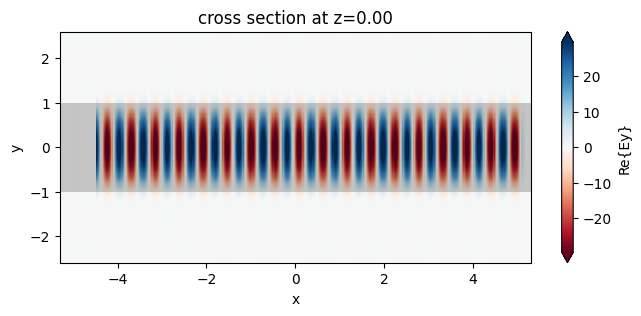

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sim_data.plot_field("field", "Ey", f=freq, ax=ax)
plt.show()

Now, let's look at the 4 modes returned by the `ModeSolver` and consider the vectorial nature of their fields to analyze their symmetries about the `y`- and `z`-directions.

- **Mode TE0**: We can observe that the `Ey` field component is continuous and the `Ez` one changes sign across the `y`-symmetry line, thus conforming to a PEC-like condition at the `y`-symmetry axis. So, this mode has symmetry **-1** (*odd, i.e. ‘PEC’ symmetry*) in the `y`-direction. At the `z`-direction, the `Hy` field component changes sign, whereas the `Hz` one is continuous at the `z`-symmetry line, thus resulting in the symmetry value **1** (*even, i.e. ‘PMC’ symmetry*). In summary, this mode has symmetry `(0, -1, 1)`.


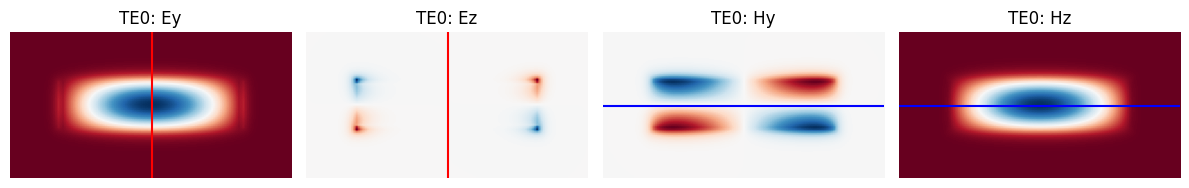

In [17]:
plot_modes(mode_data, mode_index=0, label="TE0", axis_y="red", axis_z="blue")

- **Mode TE1**: The `Ey` field component changes sign, and the `Ez` one is continuous at the `y`-symmetry line, thus conforming to a PMC-like condition at the `y`-symmetry axis. So, this mode has symmetry **1** (*even, i.e. ‘PMC’ symmetry*) in the `y`-direction. At the `z`-direction, the `Hy` field component changes sign, whereas the `Hz` one is continuous at the `z`-symmetry line, thus also conforming to a PMC-like condition. Hence, this mode has symmetry `(0, 1, 1)`.

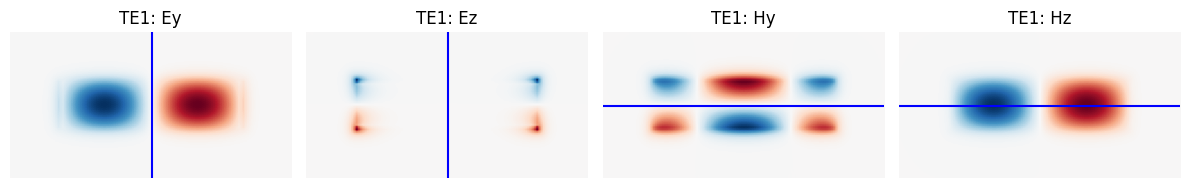

In [18]:
plot_modes(mode_data, mode_index=1, label="TE1", axis_y="blue", axis_z="blue")

- **Mode TM0**: The `Ey` field component changes sign, and the `Ez` one is continuous at the `y`-symmetry line, thus conforming to a PMC-like condition at the `y`-symmetry axis. So, this mode has symmetry **1** (*even, i.e. ‘PMC’ symmetry*) in the `y`-direction. At the `z`-direction, the `Hy` field component is continuous, whereas the `Hz` one changes sign at the `z`-symmetry line, thus conforming to a PEC-like condition. Hence, this mode has symmetry `(0, 1, -1)`.

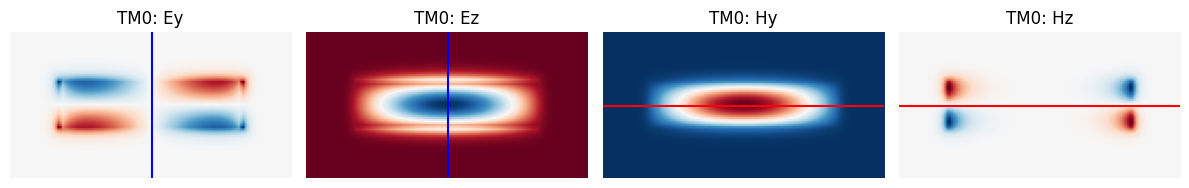

In [19]:
plot_modes(mode_data, mode_index=2, label="TM0", axis_y="blue", axis_z="red")

- **Mode TM1**: The `Ey` field component is continuous, and the `Ez` one changes sign at the `y`-symmetry line, thus conforming to a PEC-like condition at the `y`-symmetry axis. So, this mode has symmetry **-1** (*odd, i.e. ‘PEC’ symmetry*) in the `y`-direction. At the `z`-direction, the `Hy` field component is continuous, whereas the `Hz` one changes sign at the `z`-symmetry line, thus also conforming to a PEC-like condition. Hence, this mode has symmetry `(0, -1, -1)`.

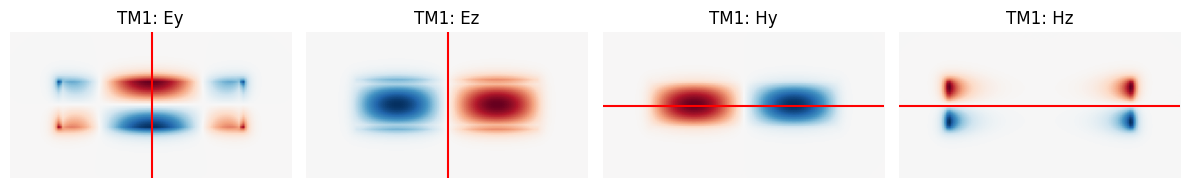

In [20]:
plot_modes(mode_data, mode_index=3, label="TM1", axis_y="red", axis_z="red")

In summary, these waveguide modes have the following symmetries:
- TE0: `(0, -1, 1)`
- TE1: `(0, 1, 1)`
- TM0: `(0, 1, -1)`
- TM1: `(0, -1, -1)`

Now, let's see the modes returned by the solver when we set these symmetry conditions.

### Symmetry (0, -1, 1)
If you turn-on the "Symmetry" visualization option after plotting the simulation, you will see the simulation domain reduced to 1/4, the **-1** (*odd, i.e. ‘PEC’ symmetry*) domain region in red, and the **1** (*even, i.e. ‘PMC’ symmetry*) domain region in blue.

In [21]:
mode_data, sim = build_simulation(symm=(0, -1, 1), n_modes=4)
sim.plot_3d(width=400, height=400)

After plotting the mode field distributions, we can observe that all the modes are TE and have the same symmetry as the TE0 one, i. e., the mode profiles have an odd number of lobes, and all of them are even-symmetric across the y-axis. That is important information when designing devices based on modal interference.

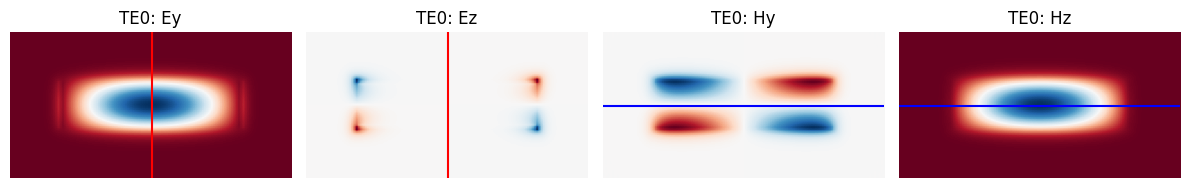

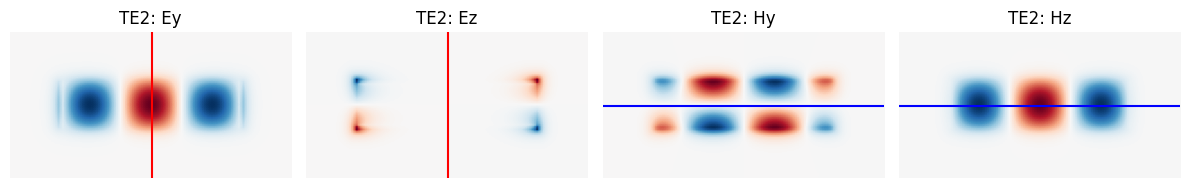

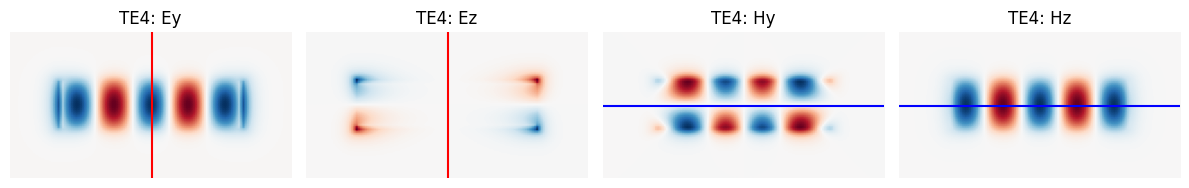

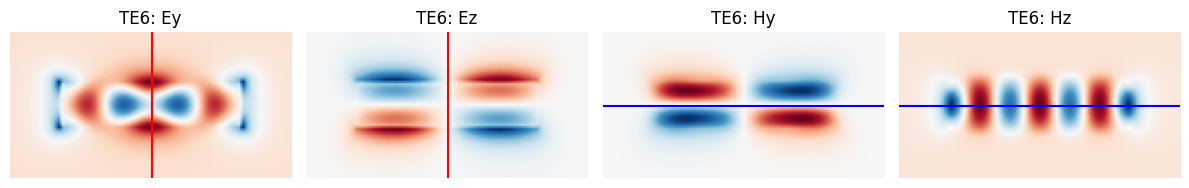

In [22]:
for m, lab in zip(range(4), ["TE0", "TE2", "TE4", "TE6"]):
    plot_modes(mode_data, mode_index=m, label=lab, axis_y="red", axis_z="blue")

### Symmetry (0, 1, 1)
In this case, all the modes share the TE1 symmetry, so they have an even number of lobes and the field distributions are odd-symmetric about the y-axis.

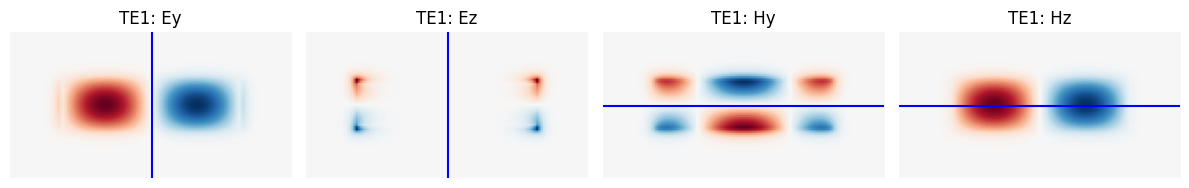

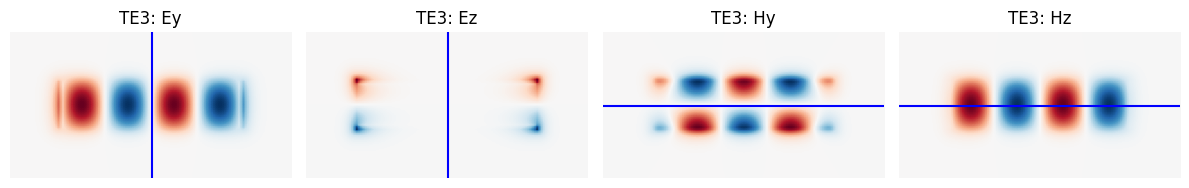

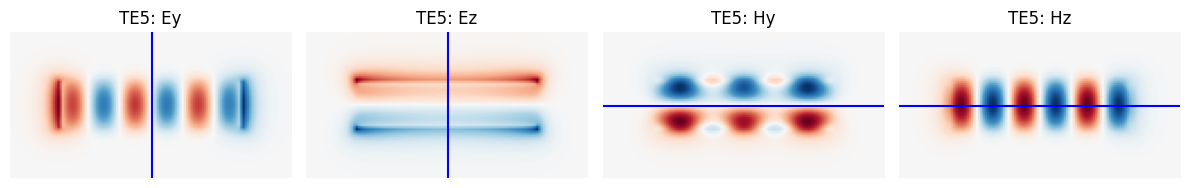

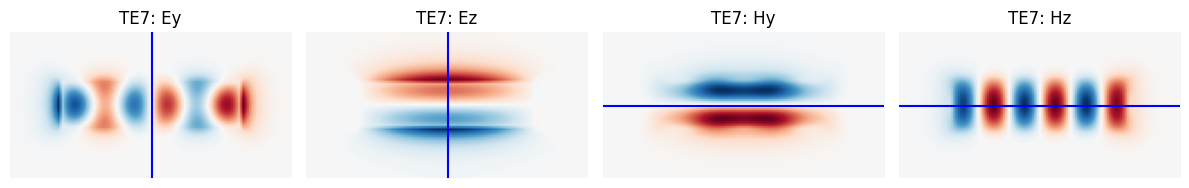

In [23]:
mode_data, sim = build_simulation(symm=(0, 1, 1), n_modes=4)
for m, lab in zip(range(4), ["TE1", "TE3", "TE5", "TE7"]):
    plot_modes(mode_data, mode_index=m, label=lab, axis_y="blue", axis_z="blue")

### Symmetry (0, 1, -1)
In this case, all the 4 modes are TM and have the same symmetry of the TM0 one.

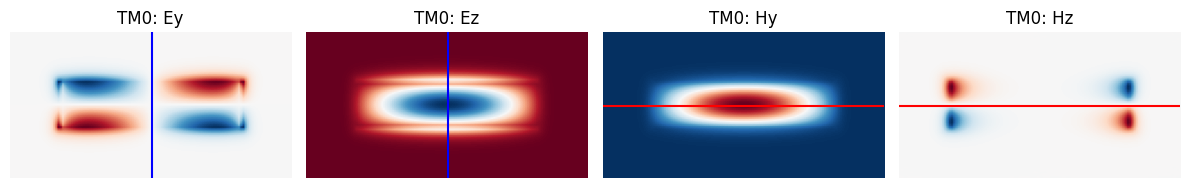

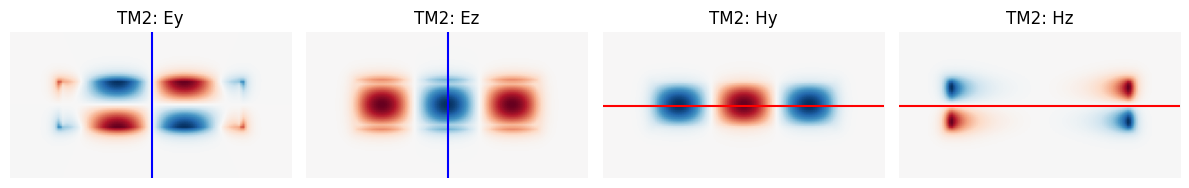

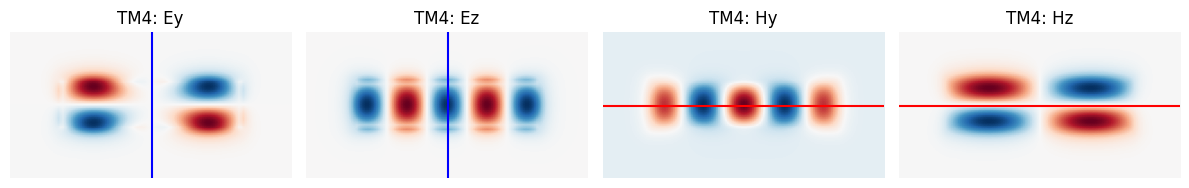

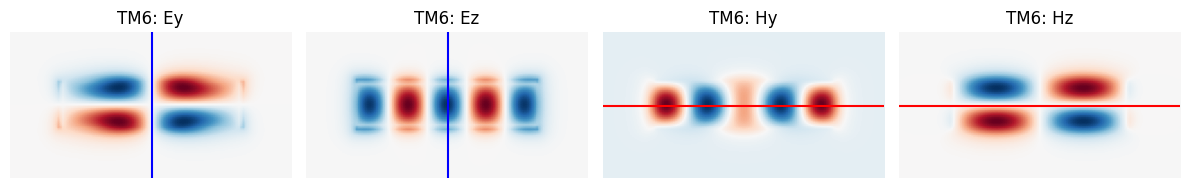

In [24]:
mode_data, sim = build_simulation(symm=(0, 1, -1), n_modes=4)
for m, lab in zip(range(4), ["TM0", "TM2", "TM4", "TM6"]):
    plot_modes(mode_data, mode_index=m, label=lab, axis_y="blue", axis_z="red")

### Symmetry (0, -1, -1)
All the 4 modes share the same symmetry of the TM1 one.

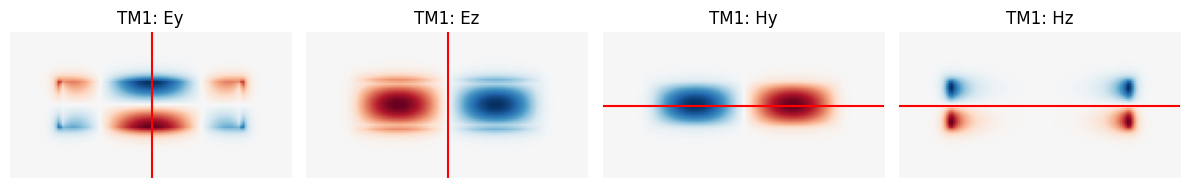

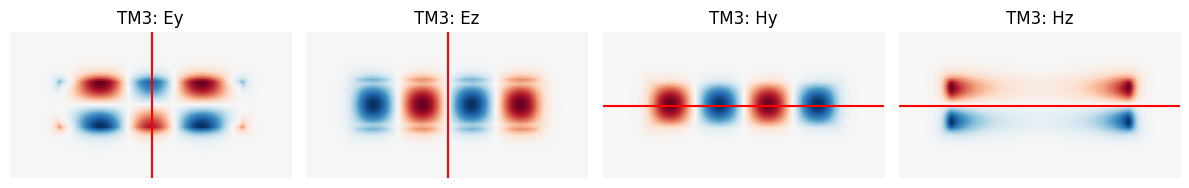

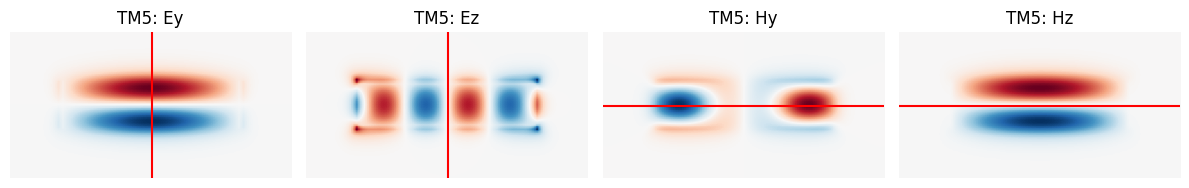

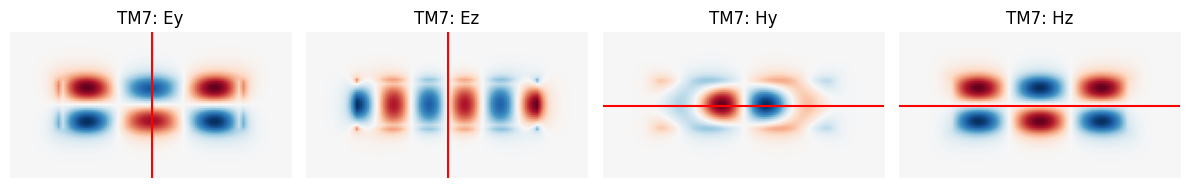

In [25]:
mode_data, sim = build_simulation(symm=(0, -1, -1), n_modes=4)
for m, lab in zip(range(4), ["TM1", "TM3", "TM5", "TM7"]):
    plot_modes(mode_data, mode_index=m, label=lab, axis_y="red", axis_z="red")

To wrap up, we will propagate the TM1 mode though the waveguide using FDTD.

In [26]:
monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq], name="field"
)
sim = sim.copy(update={"monitors": [monitor]})
job = web.Job(simulation=sim, task_name="mode_sim_tm1_symmetry", verbose=False)
sim_data = job.run(path="data/simulation_data.hdf5")

The number of grid points was reduced to 1/4, as expected due to the 4-fold symmetry. 

In [27]:
print(sim_data.log)

[08:49:14] USER: Simulation domain Nx, Ny, Nz: [424, 146, 86]                   
           USER: Applied symmetries: (0, -1, -1)                                
           USER: Number of computational grid points: 1.4378e+06.               
           USER: Using subpixel averaging: True                                 
           USER: Number of time steps: 2.0982e+04                               
           USER: Automatic shutoff factor: 1.00e-05                             
           USER: Time step (s): 4.7664e-17                                      
           USER:                                                                
                                                                                
[08:49:15] USER: Compute source modes time (s):     0.5491                      
           USER: Rest of setup time (s):            0.2601                      
[08:49:17] USER: Compute monitor modes time (s):    0.0002                      
[08:49:20] USER: Solver time

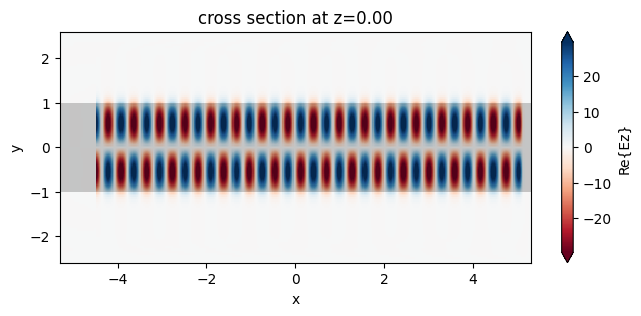

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sim_data.plot_field("field", "Ez", f=freq, ax=ax)
plt.show()